# Ch 3. Modeling with Linear Regression

- topics covered:
    - simple linear regression
    - robust linear regression
    - hierarchical linear regression
    - polynomial regression
    - multiple linear regression
    - interactions
    - variable variance

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

## Simple linear regression

### The machine learning connection

### The core of the linear regression models

- can treat solving of linear regression multiple ways:
    - OLS has the goal of minimizing a loss function
    - Bayesian uses a probabilizistic approach

$$y \sim \mathcal{N}(\mu = \alpha + x \beta, \epsilon)$$

>  A linear regression model is an extension of the Gaussian model where the mean is not directly estimated but rather computed as a linear function of a predictor variable and some additional parameters.

- set priors for the variables in the equation

$$
\alpha \sim \mathcal{N}(\mu_\alpha, \sigma_\alpha) \\
\beta \sim \mathcal{N}(\mu_\beta, \sigma_\beta) \\
\epsilon \sim | \mathcal{N}(0, \sigma_\epsilon) |
$$

<img src="assets/ch03/c5c481c3-353f-4b8f-9764-d166813e263e.png" width="75%">


- an example of fitting a linear regression with fake data

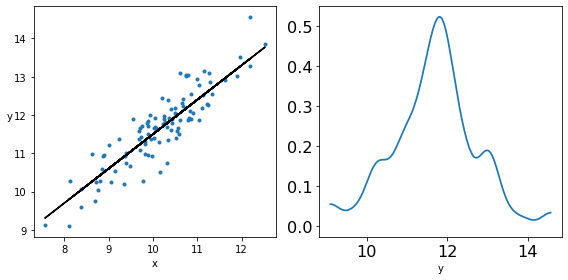

In [2]:
np.random.seed(1)
N = 100
alpha_real = 2.5
beta_real = 0.9
eps_real = np.random.normal(0, 0.5, size=N)

x = np.random.normal(10, 1, N)
y_real = alpha_real + beta_real*x
y = y_real + eps_real

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].plot(x, y, 'C0.')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y', rotation = 0)
ax[0].plot(x, y_real, 'k')

az.plot_kde(y, ax=ax[1])
ax[1].set_xlabel('y')

plt.tight_layout()
plt.show()

In [3]:
with pm.Model() as model_g:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=1)
    ϵ = pm.HalfCauchy('ϵ', 5)
    
    µ = pm.Deterministic('µ', α + β*x)
    y_pred = pm.Normal('y_pred', mu=µ, sd=ϵ, observed=y)
    
    trace_g = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, β, α]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 35 seconds.
The acceptance probability does not match the target. It is 0.885111829718544, but should be close to 0.8. Try to increase the number of tuning steps.
There were 65 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6965599556729883, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


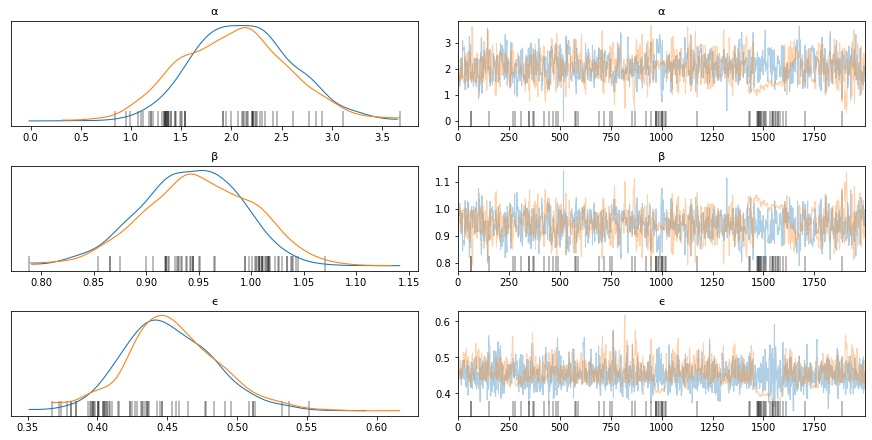

In [4]:
az_trace_g = az.from_pymc3(trace_g, model=model_g)
az.plot_trace(az_trace_g, var_names=['α', 'β', 'ϵ'])
plt.show()

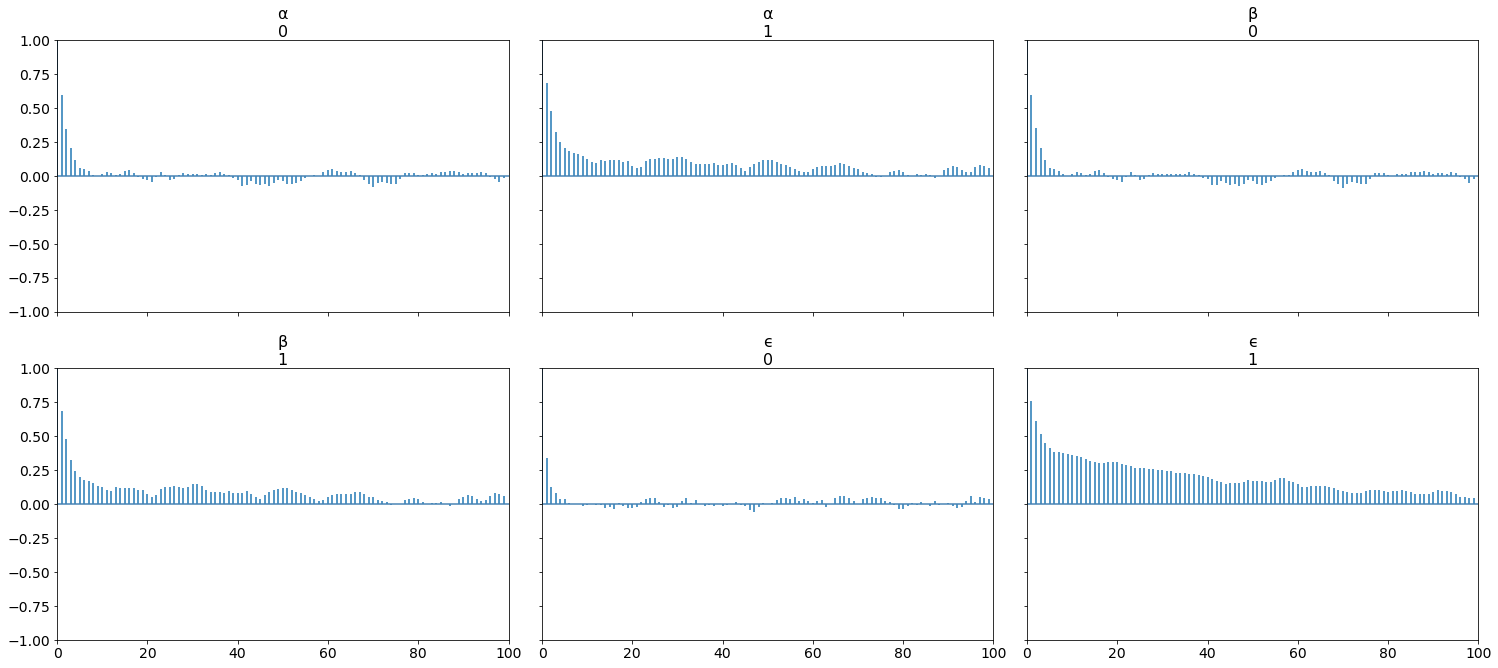

In [5]:
az.plot_autocorr(az_trace_g, var_names=['α', 'β', 'ϵ'])
plt.show()

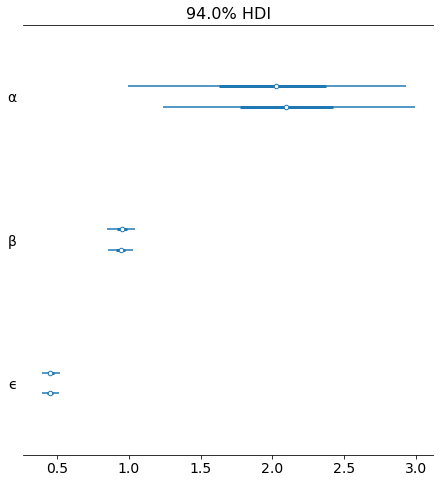

In [6]:
az.plot_forest(az_trace_g, var_names=['α', 'β', 'ϵ'])
plt.show()

In [7]:
with model_g:
    model_g_ppc = pm.sample_posterior_predictive(trace_g)

/Users/admin/Developer/Python/bayesian-analysis-with-python_e2/.env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


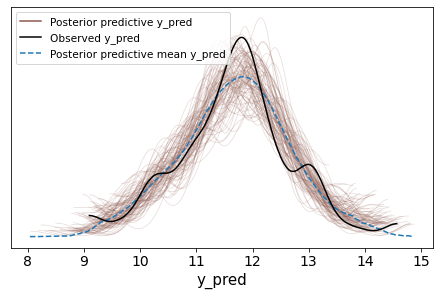

In [8]:
az.plot_ppc(az.from_pymc3(trace_g, posterior_predictive=model_g_ppc),
            num_pp_samples=100)
plt.show()

### Linear models and high autocorrelation

- the posterior distribution of $\alpha$ and $\beta$ are highly correlated as a matter of definition
    - this results in a diagonal posterior space that can be problematic for the sampling process
    - this will be discussed further in later chapters

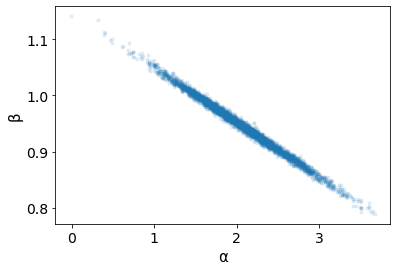

In [9]:
az.plot_pair(az_trace_g, var_names=['α', 'β'], scatter_kwargs={'alpha': 0.1})
plt.show()

#### Modifying the data before running

- centering and scaling the data can help turn the diagonal posterior into a more circular form
    - this is usually better for the sampling process

### Interpreting and visualizing the posterior

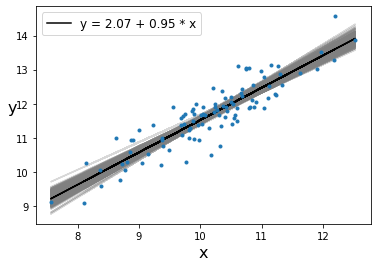

In [10]:
# Plot lines sample from the posterior.
draws = range(0, len(trace_g['α']), 10)
plt.plot(x, trace_g['α'][draws] + trace_g['β'][draws] * x[:, np.newaxis],
         c = 'gray', alpha = 0.3)

# Plot line from average of posterior.
alpha_m = trace_g['α'].mean()
beta_m = trace_g['β'].mean()
plt.plot(x, alpha_m + beta_m*x, c='k',
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

# Plot original data.
plt.plot(x, y, 'C0.')

plt.xlabel('x', fontsize=16)
plt.ylabel('y', rotation=0, fontsize=16)
plt.legend(fontsize=12)
plt.show()

- plot the **highest density interval (HDI)**

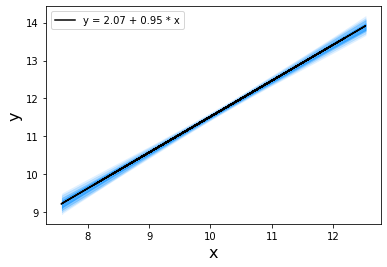

In [11]:
plt.plot(x, alpha_m + beta_m * x, c='k',
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')
for ci, c in zip([0.95, 0.89, 0.75, 0.5], ["#cfe9ff", "#99d1ff", "#52b1ff", "#058fff"]):
    az.plot_hdi(x=x, hdi_data=az.hdi(az_trace_g, hdi_prob=ci)['µ'],
                color=c, ax=plt.gca())
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.legend()
plt.show()

- also plot the HDI for $\hat{y}$
    - where the model expects to see the given percent of the data

In [12]:
ppc = pm.sample_posterior_predictive(trace_g, samples=2000, model=model_g)

/Users/admin/Developer/Python/bayesian-analysis-with-python_e2/.env/lib/python3.8/site-packages/pymc3/sampling.py:1617: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


/Users/admin/Developer/Python/bayesian-analysis-with-python_e2/.env/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/Users/admin/Developer/Python/bayesian-analysis-with-python_e2/.env/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


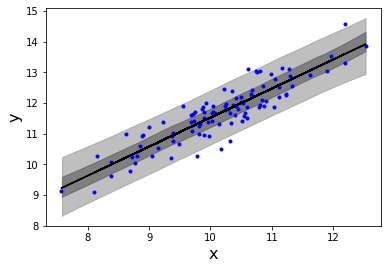

In [29]:
plt.plot(x, y, 'b.')
plt.plot(x, alpha_m + beta_m*x, c='k',
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')
az.plot_hdi(x=x, hdi_data=az.hdi(ppc['y_pred'], hdi_prob=0.5), color='black', ax=plt.gca())
az.plot_hdi(x=x, hdi_data=az.hdi(ppc['y_pred'], hdi_prob=0.95), color='gray', ax=plt.gca())

plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.show()

### Pearson correlation coefficient

#### Pearson coefficient from a multivariate Gaussian

### Robust linear regression

### Hierarchical linear regression